# Vehicle Detection Pipeline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2
import glob
import time

%matplotlib inline

# Load Image data 

In [5]:
"""
load car images
"""
def loadCarImagePaths():
    path = "img/vehicles/"
    fdirs = ["GTI_Far", "GTI_Left", "GTI_MiddleClose", "GTI_Right", "KITTI_extracted"]
    cars = []
    for d in fdirs:
        cars += glob.glob(path + d + "/*.png")
    return cars

"""
load non-car-images
"""
def loadNonCarImagePaths():
    path = "img/non-vehicles/"
    fdirs = ["Extras", "GTI"]
    noncars = []
    for d in fdirs:
        noncars += glob.glob(path + d + "/*.png")
    return noncars

carImagePaths = loadCarImagePaths()
nonCarImagePaths = loadNonCarImagePaths()
print("Number of car images: %s" %(len(carImagePaths)))
print("Number of non-car images: %s" %(len(nonCarImagePaths)))

Number of car images: 8792
Number of non-car images: 8968


# Look at some sample images

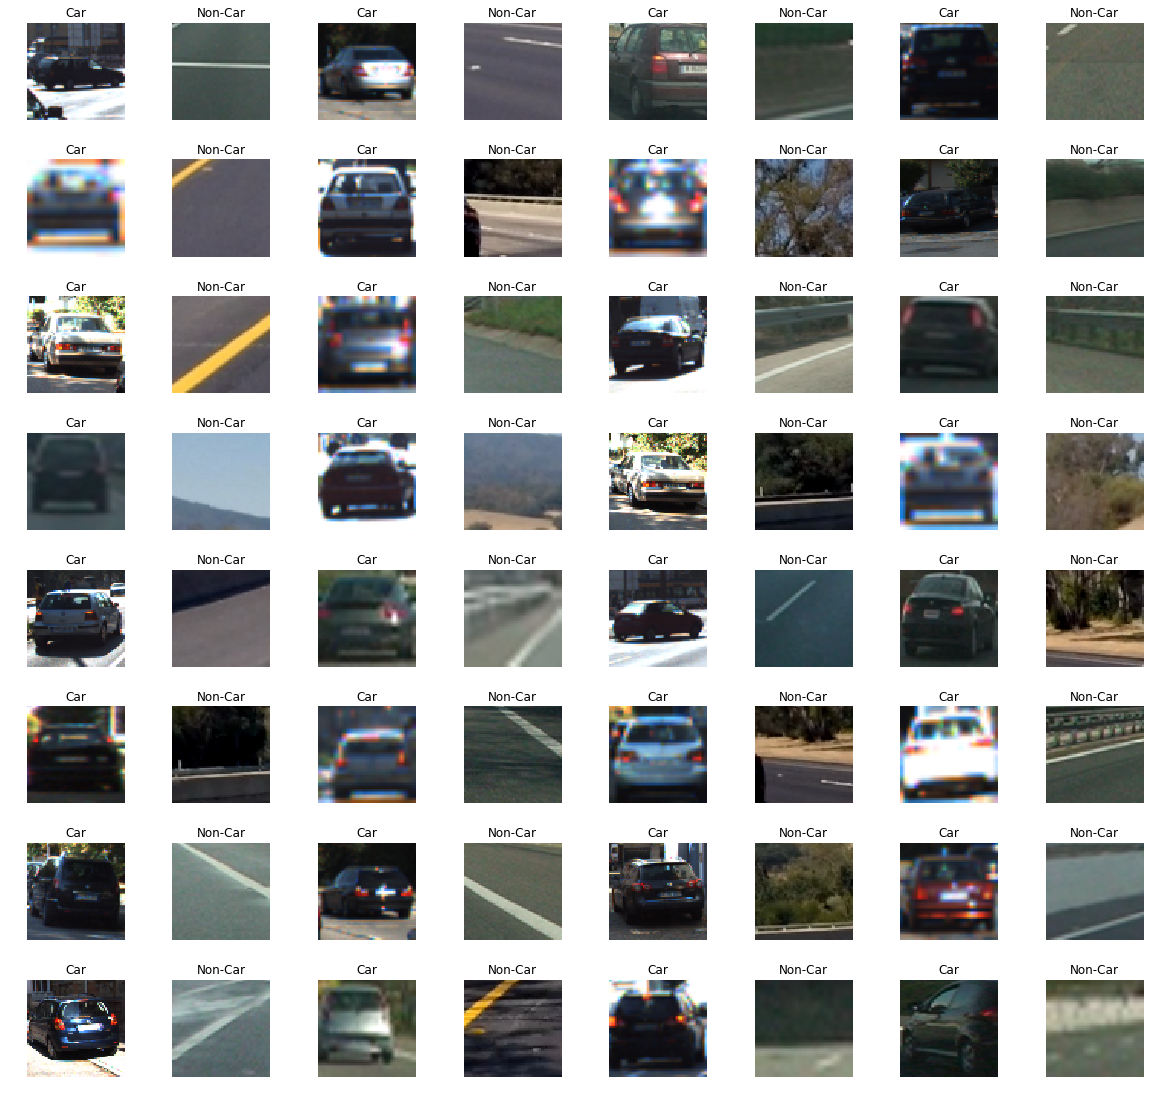

In [6]:
plt.figure(figsize = (20,20))
gs1 = gridspec.GridSpec(8, 8)
# set the spacing between axes. 
gs1.update(wspace=0.5, hspace=0.05) 

for i in range(0, 64):
    if not i%2:
        # load a random car image
        sampleCarImage = mpimg.imread(carImagePaths[np.random.randint(0, len(carImagePaths))])
        ax1 = plt.subplot(gs1[i])
        plt.axis('off')
        ax1.set_aspect('equal')
        plt.imshow(sampleCarImage, cmap='gray')
        plt.title('Car')
    else:
        # load a random non-car image
        sampleNonCarImage = mpimg.imread(nonCarImagePaths[np.random.randint(0, len(nonCarImagePaths))])
        ax1 = plt.subplot(gs1[i])
        plt.axis('off')
        ax1.set_aspect('equal')
        plt.imshow(sampleNonCarImage, cmap='gray')
        plt.title('Non-Car')
plt.show()

# Extract HOG features from the image

In [7]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Look at some HOG images  

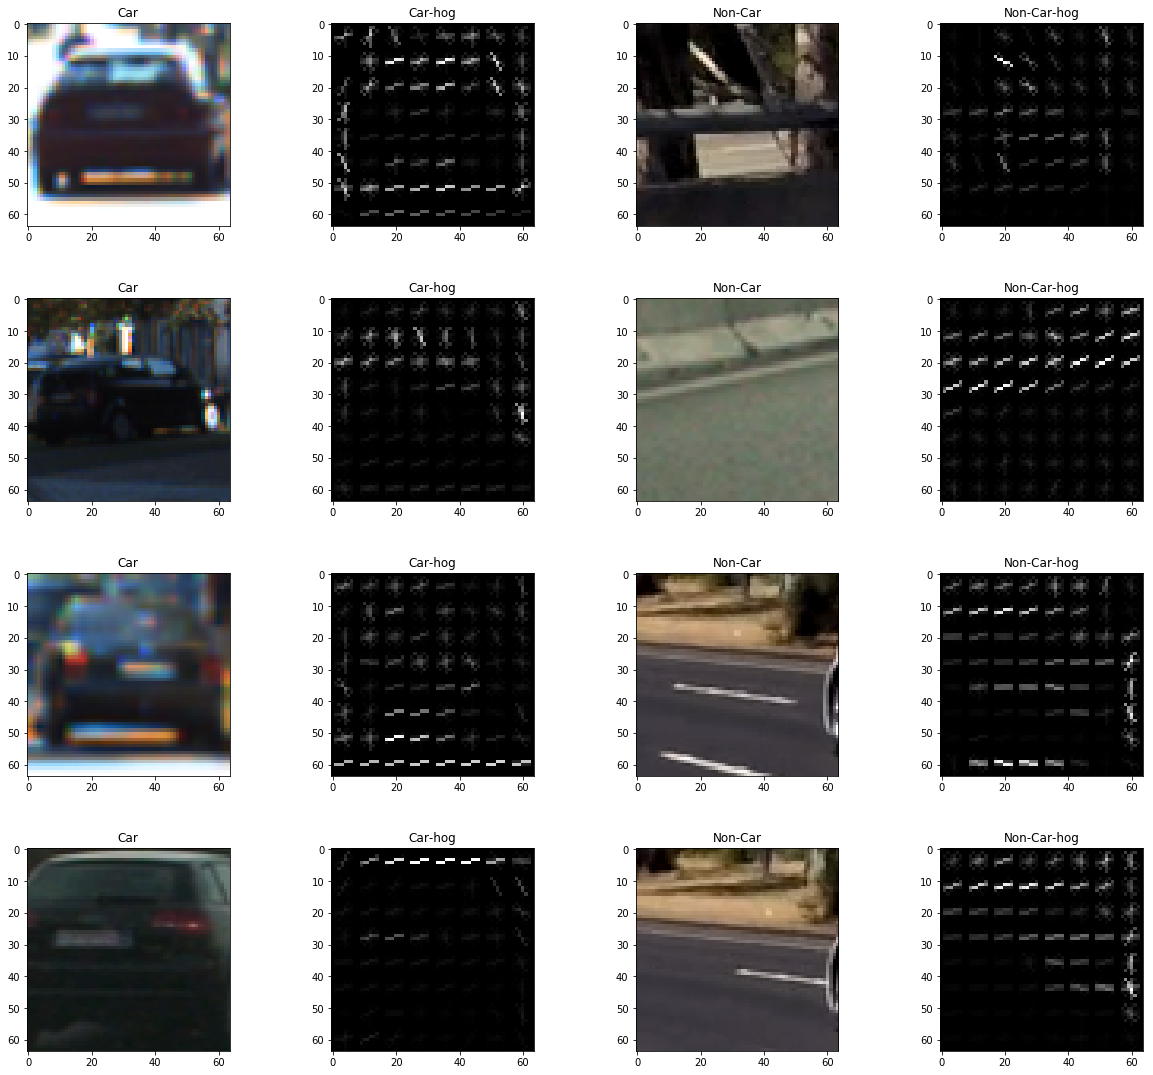

In [8]:
plt.figure(figsize = (20,20))
gs1 = gridspec.GridSpec(4, 4)
# set the spacing between axes. 
gs1.update(wspace=0.5, hspace=0.05) 

gscount = -1

for i in range(0, 8):
    if not i%2:
        gscount += 1
        # load a random car image
        sampleCarImage = mpimg.imread(carImagePaths[np.random.randint(0, len(carImagePaths))])
        _, car_dst = get_hog_features(sampleCarImage[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
        ax1 = plt.subplot(gs1[gscount])
        plt.axis('on')
        ax1.set_aspect('equal')
        plt.imshow(sampleCarImage)
        plt.title('Car')
        
        gscount += 1
        ax1 = plt.subplot(gs1[gscount])
        plt.axis('on')
        ax1.set_aspect('equal')
        plt.imshow(car_dst, cmap='gray')
        plt.title('Car-hog')
    else:
        # load a random non-car image
        
        gscount += 1
        sampleNonCarImage = mpimg.imread(nonCarImagePaths[np.random.randint(0, len(nonCarImagePaths))])
        _, noncar_dst = get_hog_features(sampleNonCarImage[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
        ax1 = plt.subplot(gs1[gscount])
        plt.axis('on')
        ax1.set_aspect('equal')
        plt.imshow(sampleNonCarImage)
        plt.title('Non-Car')
        
        gscount += 1
        ax1 = plt.subplot(gs1[gscount])
        plt.axis('on')
        ax1.set_aspect('equal')
        plt.imshow(noncar_dst, cmap='gray')
        plt.title('Non-Car-hog') 
plt.show()

# Extract HOG features from array of images

In [9]:
# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
# flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

# Extract features of the input dataset

In [10]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

car_features = extract_features(carImagePaths, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(nonCarImagePaths, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# Split feature data to Training and Test sets

In [11]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)  
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


# Train a Classifier (SVC)

In [12]:
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

2.99 Seconds to train SVC...
Test Accuracy of SVC =  0.9828
My SVC predicts:  [ 1.  1.  1.  1.  0.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  0.  0.  0.  1.]
0.0031 Seconds to predict 10 labels with SVC


# Find card in given image using trained classifier

In [13]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            hog_features = hog_features.reshape(1, -1)
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

# Find cars in sample image

In [14]:
test_img = mpimg.imread('./test_images/test1.jpg')
ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

4 rectangles found in image


# Utility function to draw rectangles on an image

In [15]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Look at the detections on a test image

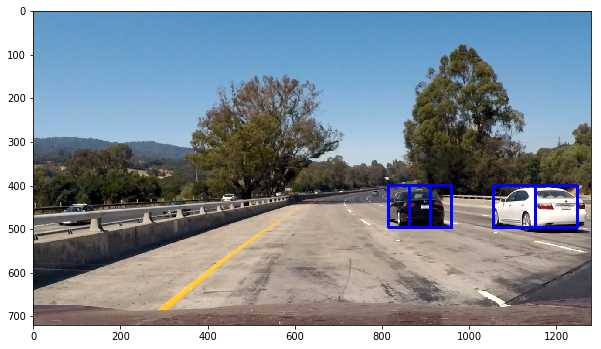

In [16]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

# Detect cars using different sizes of search window

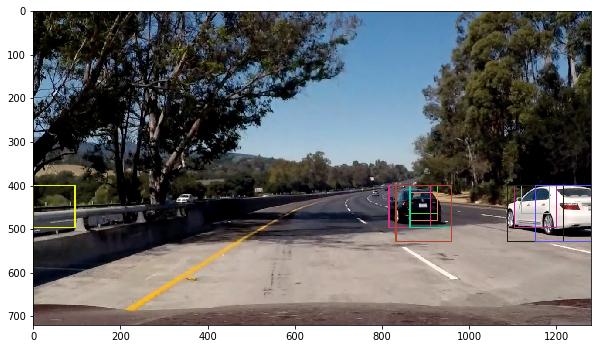

In [17]:
test_img = mpimg.imread('./test_images/test5.jpg')
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

windows = [
    {"ystart" : 400,"ystop" : 464,"scale" : 1.0},
    {"ystart" : 416,"ystop" : 480,"scale" : 1.0},
    {"ystart" : 400,"ystop" : 496,"scale" : 1.5},
    {"ystart" : 432,"ystop" : 528,"scale" : 1.5},
    {"ystart" : 400,"ystop" : 528,"scale" : 2.0},
    {"ystart" : 432,"ystop" : 560,"scale" : 2.0},
    {"ystart" : 400,"ystop" : 596,"scale" : 3.5},
    {"ystart" : 464,"ystop" : 660,"scale" : 3.5}
]

rectangles = []

for w in windows:
    rectangles.append(
        find_cars(
            test_img,
            w['ystart'],
            w['ystop'],
            w['scale'],
            colorspace,
            hog_channel,
            svc,
            None,              
            orient,
            pix_per_cell,
            cell_per_block,
            None,
            None
        )
    )


rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)


# Generate Heatmap

In [18]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# Apply heatmap to test image

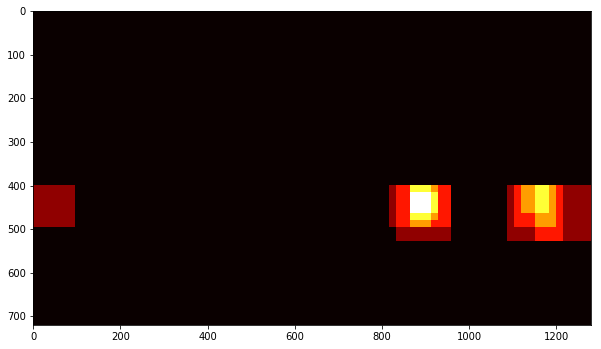

In [19]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

# Threshold utility function 

In [20]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Apply threshold to test image

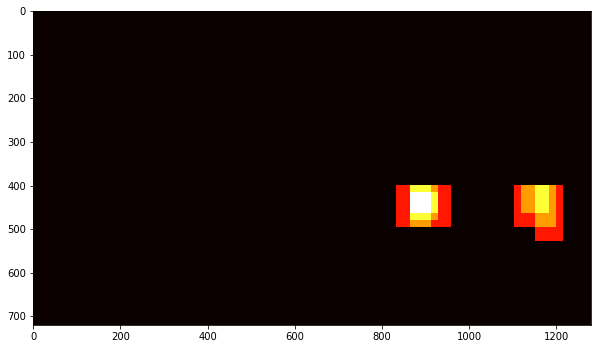

In [21]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

2 cars found


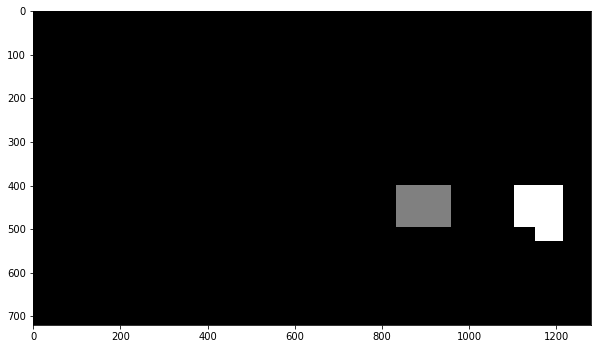

In [22]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

In [23]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

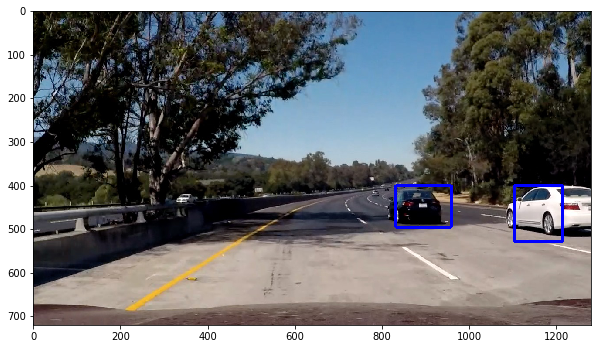

In [24]:
# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

# Build a pipleline 

### Save frames

In [25]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

In [26]:
def processFrame(img):
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    rectangles = []
    
    windows = [
    {"ystart" : 400,"ystop" : 464,"scale" : 1.0},
    {"ystart" : 416,"ystop" : 480,"scale" : 1.0},
    {"ystart" : 400,"ystop" : 496,"scale" : 1.5},
    {"ystart" : 432,"ystop" : 528,"scale" : 1.5},
    {"ystart" : 400,"ystop" : 528,"scale" : 2.0},
    {"ystart" : 432,"ystop" : 560,"scale" : 2.0},
    {"ystart" : 400,"ystop" : 596,"scale" : 3.5},
    {"ystart" : 464,"ystop" : 660,"scale" : 3.5}
    ]

    rectangles = []

    for w in windows:
        rectangles.append(
            find_cars(
                img,
                w['ystart'],
                w['ystop'],
                w['scale'],
                colorspace,
                hog_channel,
                svc,
                None,              
                orient,
                pix_per_cell,
                cell_per_block,
                None,
                None
            )
        )


    rectangles = [item for sublist in rectangles for item in sublist]
    if len(rectangles) > 0:
        det.add_rects(rectangles)
        
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
        
#     heatmap_img = add_heat(heatmap_img, rectangles)
#     heatmap_img = apply_threshold(heatmap_img, 1)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

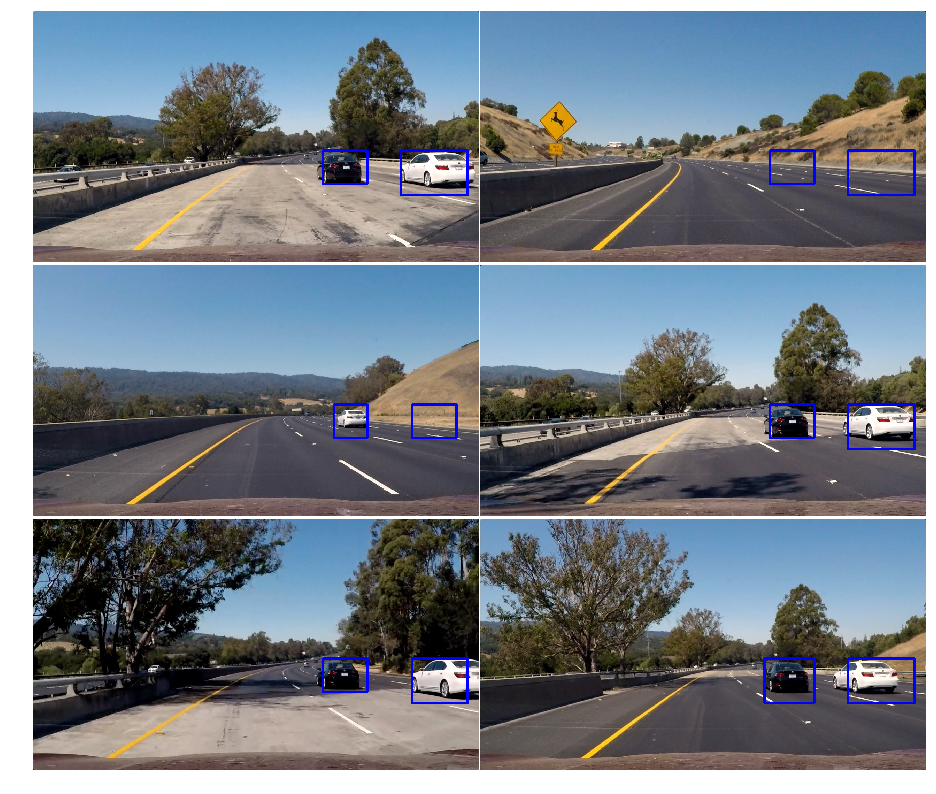

In [28]:
test_images = glob.glob('./test_images/test*.jpg')
det = Vehicle_Detect()
fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(processFrame(mpimg.imread(im)))
    axs[i].axis('off')

In [29]:
det = Vehicle_Detect()
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(processFrame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:19<00:00,  1.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 23.7 s, sys: 180 ms, total: 23.9 s
Wall time: 21.1 s


In [30]:
test_out_file = 'test_video_out.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [31]:
det = Vehicle_Detect()
proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(processFrame)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [10:55<00:00,  1.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 13min 1s, sys: 4.8 s, total: 13min 6s
Wall time: 10min 56s


In [ ]:
proj_out_file = 'project_video_out.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))